In [1]:
CODE_PATH = "../trainer"

In [2]:
import sys
sys.path.append(CODE_PATH)

In [3]:
import os
from PIL import Image

import torch
import torchvision as tv
from transformers import AutoTokenizer

from ignite.engine import (
    Engine,
    Events,
)
from ignite.handlers import Checkpoint
from ignite.contrib.handlers import global_step_from_engine
from ignite.contrib.handlers import ProgressBar
from ignite.contrib.handlers.neptune_logger import NeptuneLogger

/home/israel/Mestrado/mscenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from datamodule import SVTDataModule
from model import  OCRModel, AbstractCNN
from ctc import GreedyDecoder
from igmetrics import ExactMatch, WordF1, CER

In [5]:
tokenizer = AutoTokenizer.from_pretrained(f"{CODE_PATH}/synth-tokenizers/tokenizer-pad0")
decoder = GreedyDecoder(tokenizer.pad_token_id)

# Dataset

In [6]:
class SynthDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annotation_file, height=32):
        self.images_dir = images_dir
        self.annotation_file = annotation_file
        self.image_files = self._load_data()
        self.height = height

    def _load_data(self):
        with open(self.annotation_file, "r") as f:
            lines = f.read().splitlines()

        image_files = [line.split(" ")[0] for line in lines]
        return image_files
    
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        label = image_file.split("_")[1]
        image_path = os.path.join(self.images_dir, image_file)
        
        image = Image.open(image_path).convert("L")
        w, h = image.size
        ratio = w / float(h)
        nw = round(self.height * ratio)

        image = image.resize((nw, self.height), Image.BICUBIC)

        return image, label    
    

In [7]:
IMAGES_DIR = "../data/synth/mnt/90kDICT32px/"
TRAIN_ANNOTATION_FILE = "../data/synth/mnt/annotation_train.txt"
VAL_ANNOTATION_FILE = "../data/synth/mnt/annotation_val.txt"

In [8]:
train_dataset = SynthDataset(IMAGES_DIR, TRAIN_ANNOTATION_FILE)
val_dataset = SynthDataset(IMAGES_DIR, VAL_ANNOTATION_FILE)

# DataModule

In [9]:
from dataclasses import dataclass, field
from typing import Any

from torch.utils.data import DataLoader

In [10]:
@dataclass
class SynthDataModule:
    train_dataset: Any = field(metadata="Training dataset")
    val_dataset: Any = field(metadata="Validation dataset")
    tokenizer: Any = field(metadata="tokenizer")
    train_bs: int = field(default=16, metadata="Training batch size")
    valid_bs: int = field(default=16, metadata="Eval batch size")
    num_workers: int = field(default=2)
    max_width: int = field(default=None)

    @staticmethod
    def expand_image(img, h, w):
        expanded = Image.new("L", (w, h), color=(0,))  # black
        expanded.paste(img)
        return expanded

    def collate_fn(self, samples):
        images = [s[0] for s in samples]
        labels = [s[1] for s in samples]

        image_widths = [im.width for im in images]
        max_width = (
            self.max_width if self.max_width is not None else max(image_widths)
        )

        h = images[0].size[1]
        to_tensor = tv.transforms.ToTensor()
        images = [
            to_tensor(self.expand_image(im, h=h, w=max_width)) for im in images
        ]

        tokens = self.tokenizer.batch_encode_plus(
            labels, padding="longest", return_tensors="pt"
        )
        input_ids = tokens.get("input_ids")
        attention_mask = tokens.get("attention_mask")

        return torch.stack(images), input_ids, attention_mask

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.train_bs,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.valid_bs,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

In [40]:
datamodule = SynthDataModule(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    tokenizer=tokenizer,
    train_bs=16,
    valid_bs=16,
    num_workers=4,
)

In [41]:
train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()

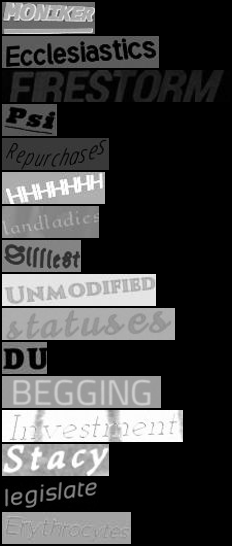

In [42]:
# use tv to visualize images
images, input_ids, attention_mask = next(iter(val_loader))
grid = tv.utils.make_grid(images, nrow=1)
tv.transforms.ToPILImage()(grid)

In [43]:
tokenizer.batch_decode(input_ids)

['MONIKER<pad><pad><pad><pad><pad><pad>',
 'Ecclesiastics',
 'FIRESTORM<pad><pad><pad><pad>',
 'Psi<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 'Repurchases<pad><pad>',
 'PIGTAIL<pad><pad><pad><pad><pad><pad>',
 'landladies<pad><pad><pad>',
 'Silliest<pad><pad><pad><pad><pad>',
 'Unmodified<pad><pad><pad>',
 'statuses<pad><pad><pad><pad><pad>',
 'DU<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 'BEGGING<pad><pad><pad><pad><pad><pad>',
 'Investment<pad><pad><pad>',
 'Stacy<pad><pad><pad><pad><pad><pad><pad><pad>',
 'legislate<pad><pad><pad><pad>',
 'Erythrocytes<pad>']

# Model

In [44]:
from torch import nn

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
class Feature2Embedding(nn.Module):
    def forward(self, x):
        n, c, h, w = x.shape
        assert h == 1, "the height of out must be 1"
        x = x.squeeze(2) # [n, c, w]
        return x.permute(0, 2, 1) # [n, w, c]

class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels, st=(2,1)):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            Swish()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=st, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=st, padding=0),
            nn.BatchNorm2d(out_channels),
        )

        self.swish = Swish()

    def forward(self, x):
        input = x
        x = self.conv1(x)
        x = self.conv2(x) + self.downsample(input)
        x = self.swish(x)
        return x

class ResNetLike(nn.Module):
    """
    Custom CNN
    """

    def __init__(
        self,
        vocab_size: int = 100,
        p: float = 0.0,
    ):
        super().__init__()

        self.image_embeddings = nn.Sequential(
            self.block(1, 64, st=(2, 2)),
            nn.Dropout2d(p),
            self.block(64, 128, st=(2, 2)),
            nn.Dropout2d(p),
            self.block(128, 256, st=(2, 1)),
            nn.Dropout2d(p),
            self.block(256, 512, st=(4, 1)),
            nn.Dropout2d(p),
            Feature2Embedding(),
        )
        self.lm_head = nn.Linear(512, vocab_size)

    def block(self, in_channels, out_channels, st=2):
        return ResidualBlock(in_channels=in_channels, out_channels=out_channels, st=st)
    
    def forward(self, images, *args, **kwargs):
        embedding = self.image_embeddings(images)
        logits = self.lm_head(embedding)
        return logits

    def lm(self, embedding):
        return self.lm_head(embedding)

In [45]:
model = ResNetLike(vocab_size=tokenizer.vocab_size, p=0.0)

In [46]:
_ = model.to("cpu")

In [47]:
batch = next(iter(train_loader))
with torch.no_grad():
    images, labels, attention_mask = batch
    logits = model(images)
logits.shape

torch.Size([16, 40, 68])

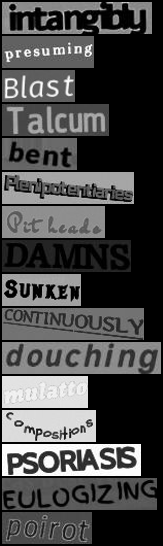

In [48]:
# display images using torchvision utils make_grid
grid = tv.utils.make_grid(images, nrow=1)
tv.transforms.ToPILImage()(grid)

In [49]:
attention_mask.sum(-1), labels

(tensor([10,  9,  5,  6,  4, 17,  8,  5,  6, 12,  8,  7, 12,  9, 10,  6]),
 tensor([[51, 56, 62, 43, 56, 49, 51, 44, 54, 67,  0,  0,  0,  0,  0,  0,  0],
         [58, 60, 47, 61, 63, 55, 51, 56, 49,  0,  0,  0,  0,  0,  0,  0,  0],
         [18, 54, 43, 61, 62,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [36, 43, 54, 45, 63, 55,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [44, 47, 56, 62,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [32, 54, 47, 56, 51, 58, 57, 62, 47, 56, 62, 51, 43, 60, 51, 47, 61],
         [32, 51, 62, 50, 47, 43, 46, 61,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [20, 17, 29, 30, 35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [35, 63, 56, 53, 47, 56,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [19, 31, 30, 36, 25, 30, 37, 31, 37, 35, 28, 41,  0,  0,  0,  0,  0],
         [46, 57, 63, 45, 50, 51, 56, 49,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [55, 63, 54, 43, 62, 62, 57,  0,  0,  0,  0,  0

In [50]:
tokenizer.batch_decode(labels, skip_special_tokens=False)

['intangibly<pad><pad><pad><pad><pad><pad><pad>',
 'presuming<pad><pad><pad><pad><pad><pad><pad><pad>',
 'Blast<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 'Talcum<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 'bent<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 'Plenipotentiaries',
 'Pitheads<pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 'DAMNS<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 'Sunken<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 'CONTINUOUSLY<pad><pad><pad><pad><pad>',
 'douching<pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 'mulatto<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 'compositions<pad><pad><pad><pad><pad>',
 'PSORIASIS<pad><pad><pad><pad><pad><pad><pad><pad>',
 'EULOGIZING<pad><pad><pad><pad><pad><pad><pad>',
 'poirot<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']

In [51]:
logits.argmax(-1)

tensor([[ 4, 32, 28, 54, 21,  9, 21, 54, 56, 54, 21, 56, 13,  9, 41, 67, 41, 43,
         54, 37, 21, 54, 65, 42, 54,  6, 35, 54,  0,  6, 52, 35, 40, 50,  9, 57,
         11, 18, 18,  4],
        [ 9, 54, 21, 54, 67, 32, 21, 67, 54, 67, 12, 54, 14, 21, 30, 46, 32, 54,
          0, 67,  6, 32, 19, 41,  1,  4, 42, 51, 51, 51, 51, 51, 51, 51, 51, 51,
         51, 51, 51, 57],
        [33, 64, 14, 54, 30, 32, 28, 54, 67, 54, 30, 54, 54, 67, 67, 54, 12, 42,
         11,  4, 42, 42, 42, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
         51, 51, 51, 57],
        [ 9, 43, 43, 43, 57, 54, 54, 54, 30, 54, 21, 32, 43, 54, 54, 54, 54, 32,
         30, 54, 54, 30, 54, 54, 30, 54, 21, 34, 66, 14, 42, 51, 51, 51, 51, 51,
         51, 51, 51, 57],
        [54, 21, 21, 54, 43, 54, 21, 21, 54, 54, 54, 54, 54, 54, 54, 21, 54, 54,
         21, 38, 54,  4, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
         51, 51, 51, 57],
        [46, 52, 20, 10, 56, 14,  9,  9,  9, 12, 13,  8, 15,

# Ignite

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [53]:
_ = model.to(device)

In [54]:
MAX_EPOCHS=2
STEPS = len(train_loader) * MAX_EPOCHS
STEPS

903078

In [67]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, STEPS, 1e-5)
criterion = torch.nn.CTCLoss(blank=tokenizer.pad_token_id, zero_infinity=True)

In [68]:
def get_preds_from_logits(logits, labels):
    decoded_ids = logits.argmax(-1).squeeze(0)
    if len(decoded_ids.shape) == 1:
        decoded_ids = decoded_ids.unsqueeze(0)
    
    decoded = [
        decoder(dec, None) for dec in decoded_ids
    ]
    y_pred = tokenizer.batch_decode(decoded, skip_special_tokens=True)
    y = tokenizer.batch_decode(labels, skip_special_tokens=True)
    return y_pred, y

In [69]:
def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()

    images, labels, attention_mask = [x.to(device) if x is not None else x for x in batch]

    logits = model(images)
    
    input_length = torch.full(
        size=(logits.size(0),),
        fill_value=logits.size(1),
        dtype=torch.int32,
        device=logits.device,
    )

    target_length = attention_mask.sum(-1)

    logits = logits.permute(1, 0, 2)
    logits = logits.log_softmax(2)

    loss = criterion(logits, labels, input_length, target_length)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    lr_scheduler.step()
    return loss.item()

In [70]:
def val_step(engine, batch):
    model.eval()
    images, labels, _ = [x.to(device) if x is not None else x for x in batch]
    with torch.no_grad():
        logits = model(images)

    y_pred, y = get_preds_from_logits(logits, labels)
    return y_pred, y
    

In [71]:
batch = next(iter(val_loader))
for _ in range(1000):
    loss = train_step(None, batch)
    print(loss)

0.2346896082162857
9.870843887329102
10.516992568969727
6.486246109008789
4.685739994049072
4.120902061462402
3.598857879638672
3.1519646644592285
2.430325984954834
2.2094411849975586
2.5734949111938477
1.845954418182373
1.552351713180542
1.3459868431091309
1.218446969985962
1.2833553552627563
0.9712370038032532
1.167921543121338
1.0085701942443848
0.8071085214614868
0.697725772857666
0.6023427248001099
0.5674574375152588
0.5757898092269897
0.45904046297073364
0.39098238945007324
0.33959490060806274
0.27787166833877563
0.2426680326461792
0.21829602122306824
0.206888347864151
0.2172633409500122
0.1790391206741333
0.19430725276470184
0.17980314791202545
0.17256370186805725
0.16699662804603577
0.1568441092967987
0.17210544645786285
0.15093791484832764
0.15862509608268738
0.149588942527771
0.15531125664710999
0.14368900656700134
0.1456322968006134
0.14256446063518524
0.14403927326202393
0.14297673106193542
0.14112889766693115
0.14103816449642181
0.1390351951122284
0.14126406610012054
0.139

KeyboardInterrupt: 

In [72]:
y_pred, y = val_step(None, batch)
from igmetrics import compute_exact
[compute_exact(pred, gt) for pred, gt in zip(y_pred, y)]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0]

In [54]:
trainer = Engine(train_step)
train_evaluator = Engine(val_step)
validation_evaluator = Engine(val_step)

In [53]:
def log_validation_results(engine):
    validation_evaluator.run(val_loader)
    metrics = validation_evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    print(f"Validation Results - Epoch: {engine.state.epoch}  Avg accuracy: {avg_accuracy:.3f}")

In [55]:
ExactMatch().attach(validation_evaluator, "accuracy")

trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

In [58]:
to_save = {'model': model}
handler = Checkpoint(
    to_save, 
    "svt-checkpoint-models",
    n_saved=1, 
    filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer)
)
validation_evaluator.add_event_handler(Events.COMPLETED, handler)

In [85]:
neptune_logger = NeptuneLogger(
    project="i155825/TRecPretrain",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhOGUyY2VlOS1hZTU5LTQ2NGQtYTY5Zi04OGJmZWM2M2NlMDAifQ==",
)

neptune_logger.attach_output_handler(
    trainer,
    event_name=Events.ITERATION_COMPLETED,
    tag="training",
    output_transform=lambda loss: {"loss": loss},
)

neptune_logger.attach_output_handler(
    validation_evaluator,
    event_name=Events.EPOCH_COMPLETED,
    tag="validation",
    metric_names=["accuracy"],
    global_step_transform=global_step_from_engine(trainer),  
)

neptune_logger.attach_output_handler(
    train_evaluator,
    event_name=Events.EPOCH_COMPLETED,
    tag="training",
    metric_names=["accuracy"],
    global_step_transform=global_step_from_engine(trainer),  
)

neptune_logger["code"].upload_files([
    f"{CODE_PATH}/*.py", 
    f"{CODE_PATH}/**/*.py",
    __file__
])

https://app.neptune.ai/i155825/SVT/e/SVT-2


NameError: name 'train_evaluator' is not defined

In [56]:
pbar = ProgressBar()
pbar.attach(trainer, output_transform=lambda x: {'loss': x})

In [57]:
trainer.run(train_loader, max_epochs=MAX_EPOCHS)

Validation Results - Epoch: 1  Avg accuracy: 0.000


Validation Results - Epoch: 2  Avg accuracy: 0.000


Validation Results - Epoch: 3  Avg accuracy: 0.000


Validation Results - Epoch: 4  Avg accuracy: 0.000


Validation Results - Epoch: 5  Avg accuracy: 0.000


Validation Results - Epoch: 6  Avg accuracy: 0.000


Validation Results - Epoch: 7  Avg accuracy: 0.000


Validation Results - Epoch: 8  Avg accuracy: 0.000


Validation Results - Epoch: 9  Avg accuracy: 0.000


Validation Results - Epoch: 10  Avg accuracy: 0.000


Validation Results - Epoch: 11  Avg accuracy: 0.000


Validation Results - Epoch: 12  Avg accuracy: 0.000


Validation Results - Epoch: 13  Avg accuracy: 0.000


Validation Results - Epoch: 14  Avg accuracy: 0.000


Validation Results - Epoch: 15  Avg accuracy: 0.000


Validation Results - Epoch: 16  Avg accuracy: 0.000


Validation Results - Epoch: 17  Avg accuracy: 0.000


Validation Results - Epoch: 18  Avg accuracy: 0.000


Validation Results - Epoch: 19  Avg accuracy: 0.000


Engine run is terminating due to exception: 


KeyboardInterrupt: 

In [46]:
batch = next(iter(dm.val_dataloader()))

In [47]:
y_pred, y = val_step(None, batch)

In [48]:
y_pred, y

(['SHAEOAP', 'SOAE', 'SOM', 'HEUEN'], ['SING', 'YANK', 'BIERSCH', 'BREWERY'])

Epoch [4/100]: [8/54]  15%|█▍        , loss=0.0328 [00:19<00:02]